# Importo librerias que voy a utilizar

In [155]:
!pip install textacy
!pip install catboost
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
import textacy
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import urllib.parse
import html
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Leo el set de datos

In [156]:
train_original = pd.read_csv('https://raw.githubusercontent.com/maxrinal/nlp-disaster/master/train.csv')
test_original = pd.read_csv('https://raw.githubusercontent.com/maxrinal/nlp-disaster/master/test.csv')

In [158]:
train = train_original.copy()
test = test_original.copy()

# Remuevo columnas keyword y location para enfocarme en el text

In [159]:
train=train.drop(columns=['keyword', 'location'])
test = test.drop(columns=['keyword', 'location'])
test.sample(10)

,id,text
3134,10397,Warcraft has always been this weird referentia...
1563,5261,@Dat_Vi fear of the unknown eh.
578,1876,@sar_giuliani I'm currently burning my skin off??
1333,4400,hmm what if I've already met my special someon...
1261,4148,I'm incredibly sad &amp; heartbroken so I'm ju...
1029,3375,Buzzing: Billy Joel Brings Down the House for ...
1013,3331,Uttarakhand: Journalist's house demolished who...
1052,3453,@CoolBreezeT train derailed at Smithsonian...n...
1680,5679,Who is bringing the tornadoes and floods. Who ...
3230,10738,Wreckage 'Conclusively Confirmed' as From MH37...


# Realizo una limpieza del set de datos

In [160]:
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
test.sample(10)

,id,text
1102,3624,#nowplaying - lamb of god - desolation http:/...
3250,10820,@stighefootball begovic has been garbage. he g...
2822,9370,you'll be pleased to know i survived my dental...
571,1859,omg so last week i accidentally burned myself ...
1311,4315,photo: susfu: dust storm rolling onto the base...
1577,5327,amazon kindle fire 7' fast repair service for ...
1729,5838,twin storms blow through calgary * 75 http://t...
351,1135,lots of talk of how susceptible ny2 is to shoo...
1618,5447,allergan kicks off refresh america program to ...
1450,4811,pelling hotels: no strings concealment from st...


In [161]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

train['text'] = train.text.apply(lambda x: remove_punctuation(x))
test['text'] = test.text.apply(lambda x: remove_punctuation(x))

train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [162]:
STOPWORDS = set(stopwords.words('english') +  ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
def stopwords_(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

train['text'] = train['text'].apply(lambda text: stopwords_(text))
test['text'] = test['text'].apply(lambda text: stopwords_(text))

train['text'].head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    13000 people receive wildfires evacuation orde...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

In [163]:
train['text'] = train['text'].apply(lambda text: html.unescape(text))
test['text'] = test['text'].apply(lambda text: html.unescape(text))
train['text'] = train['text'].apply(lambda text: urllib.parse.unquote(text))
test['text'] = test['text'].apply(lambda text: urllib.parse.unquote(text))

train['text'] = train['text'].apply(lambda x: ' '.join([re.sub('[^A-Za-z?!]+', ' ', word ) for word in x.split()]))

Lematizacion

In [164]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatizer_(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

train['text'] = train['text'].apply(lambda text: lemmatizer_(text))
test['text'] = test['text'].apply(lambda text: lemmatizer_(text))

Saco numeros

In [165]:
train.text = train.text.str.translate(str.maketrans('','','1234567890'))
test.text = test.text.str.translate(str.maketrans('','','1234567890'))

# Features

In [166]:
train['text_len'] = train['text'].apply(len)

Text(0.5, 0, 'Text length')

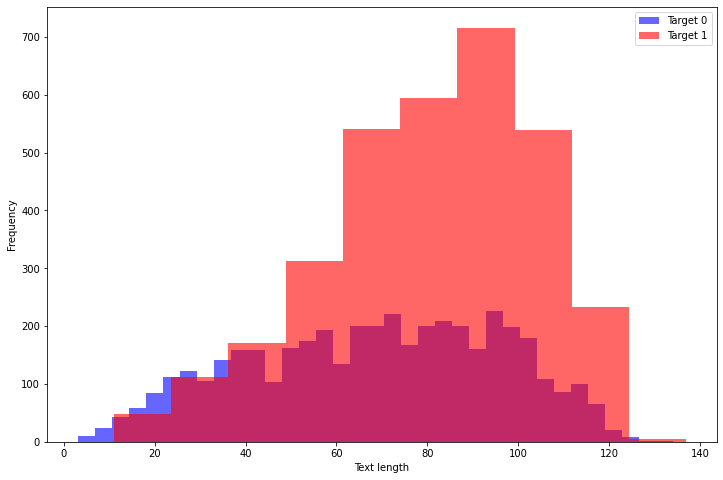

In [167]:
plt.figure(figsize=(12, 8))

train[train.target==0].text_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Target 0', alpha=0.6)
train[train.target==1].text_len.plot(kind='hist', color='red', 
                                       label='Target 1', alpha=0.6)
plt.legend()
plt.xlabel("Text length")

In [168]:
train[train.target==0].describe()

,id,target,text_len
count,4342.000000,4342.0,4342.000000
mean,5276.446338,0.0,68.192999
std,3157.206802,0.0,27.677472
min,23.000000,0.0,3.000000
25%,2513.250000,0.0,47.000000
50%,5243.500000,0.0,70.000000
75%,8038.500000,0.0,91.000000
max,10848.000000,0.0,134.000000


In [169]:
train[train.target==1].describe()

,id,target,text_len
count,3271.000000,3271.0,3271.000000
mean,5661.608071,1.0,80.804341
std,3097.094809,0.0,23.205680
min,1.000000,1.0,11.000000
25%,3104.500000,1.0,65.000000
50%,5676.000000,1.0,84.000000
75%,8252.000000,1.0,99.000000
max,10873.000000,1.0,137.000000


Miro cuales son las palabras mas frecuentes para target 0 y target 1

In [170]:
from collections import Counter

words = train[train.target==0].text.apply(lambda x: [word.lower() for word in x.split()])
target0 = Counter()

for msg in words:
    target0.update(msg)
    
print(target0.most_common(50))

[('httptco', 306), ('like', 255), ('amp', 193), ('get', 185), ('new', 171), ('one', 137), ('body', 117), ('u', 114), ('time', 106), ('video', 102), ('via', 99), ('day', 98), ('would', 97), ('love', 95), ('go', 93), ('people', 93), ('know', 90), ('s', 89), ('fire', 88), ('let', 86), ('back', 85), ('see', 84), ('got', 84), ('bag', 83), ('full', 82), ('emergency', 82), ('cant', 81), ('want', 81), ('make', 76), ('youtube', 76), ('going', 75), ('look', 72), ('still', 72), ('world', 72), ('need', 70), ('think', 69), ('w', 69), ('x', 69), ('life', 68), ('good', 67), ('man', 64), ('year', 64), ('say', 64), ('rt', 62), ('news', 62), ('woman', 62), ('lol', 61), ('way', 60), ('first', 59), ('v', 59)]


In [171]:
words = train[train.target==1].text.apply(lambda x: [word.lower() for word in x.split()])
target1 = Counter()

for msg in words:
    target1.update(msg)
    
print(target1.most_common(50))

[('httptco', 384), ('fire', 264), ('news', 146), ('via', 121), ('disaster', 118), ('california', 115), ('u', 112), ('suicide', 110), ('amp', 109), ('police', 107), ('people', 106), ('family', 105), ('home', 100), ('train', 100), ('building', 95), ('pm', 94), ('killed', 93), ('like', 92), ('storm', 91), ('bomb', 91), ('hiroshima', 91), ('crash', 89), ('year', 86), ('s', 81), ('wildfire', 80), ('flood', 79), ('emergency', 76), ('attack', 76), ('bombing', 75), ('car', 73), ('mh', 73), ('two', 72), ('accident', 72), ('video', 72), ('nuclear', 71), ('get', 70), ('one', 70), ('time', 70), ('death', 66), ('say', 66), ('i', 65), ('northern', 64), ('burning', 64), ('dead', 63), ('legionnaire', 62), ('war', 61), ('bomber', 61), ('m', 59), ('life', 59), ('r', 58)]


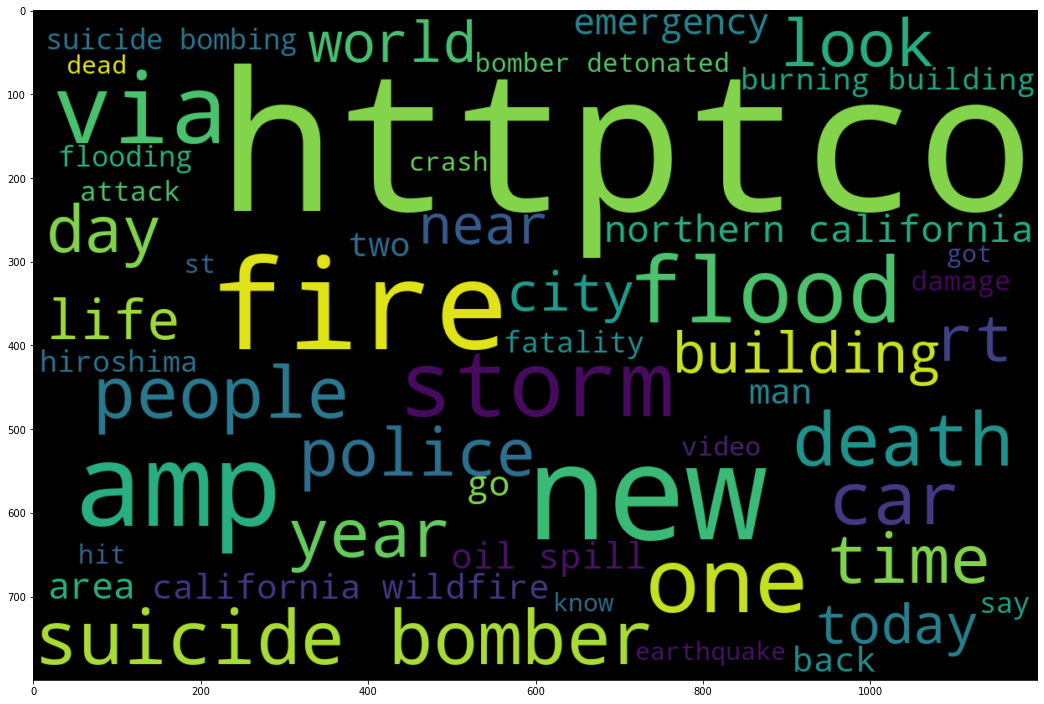

In [172]:
t1 = train.text[train.target[train.target==1].index]
plt.figure(figsize = (18,24))
wordcloud = WordCloud(min_font_size = 3,  max_words = 50 , width = 1200 , height = 800).generate(" ".join(t1))
plt.imshow(wordcloud,interpolation = 'bilinear')

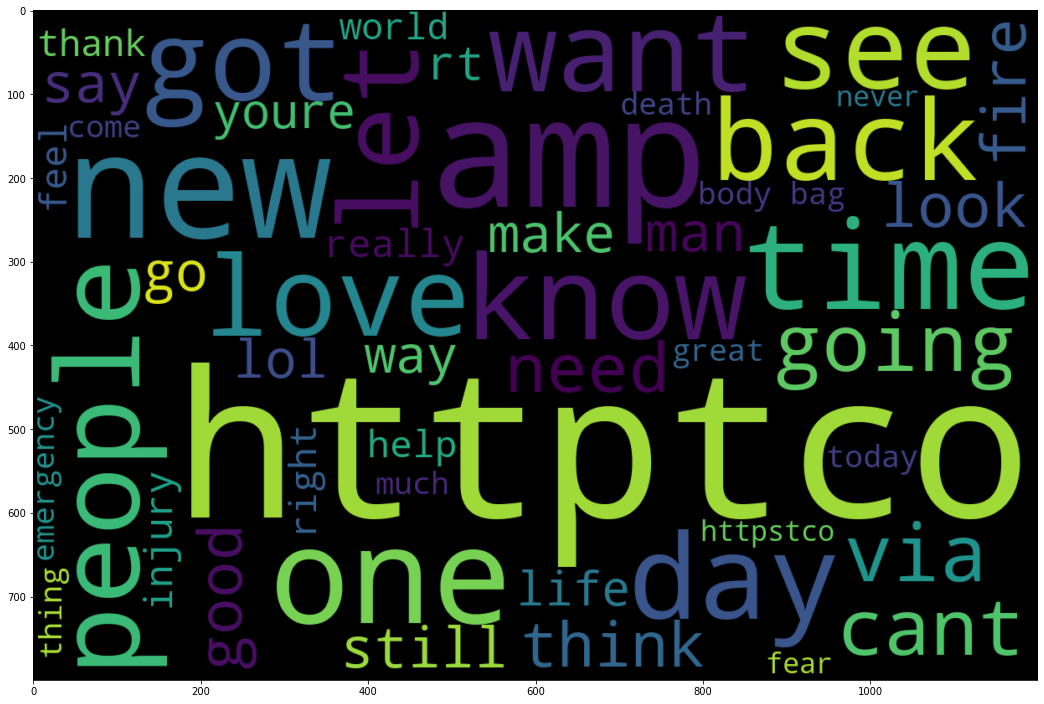

In [173]:
t0 = train.text[train.target[train.target==0].index]
plt.figure(figsize = (18,24))
wordcloud = WordCloud(min_font_size = 3,  max_words = 50 , width = 1200 , height = 800).generate(" ".join(t0))
plt.imshow(wordcloud,interpolation = 'bilinear')

Bag of words

In [174]:
X = train.text
y = train.target
print(X.shape)
print(y.shape)

(7613,)
(7613,)


In [175]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6090,)
(1523,)
(6090,)
(1523,)


In [176]:
vect = CountVectorizer(stop_words='english')
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm

<6090x18399 sparse matrix of type '<class 'numpy.int64'>'
	with 56203 stored elements in Compressed Sparse Row format>

In [177]:
X_test_dtm = vect.transform(X_test)
X_test_dtm

<1523x18399 sparse matrix of type '<class 'numpy.int64'>'
	with 10849 stored elements in Compressed Sparse Row format>

In [178]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<6090x18399 sparse matrix of type '<class 'numpy.float64'>'
	with 56203 stored elements in Compressed Sparse Row format>

# Pruebo modelo RandomForest

Pruebo con los hiperparametros por defecto (100 arboles)

In [179]:
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(X_train_dtm, y_train)
preds = rf_model.predict(X_test_dtm)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.464074


In [180]:
rf_model.feature_importances_

array([5.33682801e-06, 0.00000000e+00, 2.69113108e-04, ...,
       0.00000000e+00, 1.51478368e-06, 0.00000000e+00])

Pruebo con 5 arboles

In [181]:
rf_model = RandomForestClassifier(random_state=1, n_estimators=5)


rf_model.fit(X_train_dtm, y_train)
preds = rf_model.predict(X_test_dtm)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.475258


Pruebo con 100 arboles y 30 features

In [183]:
rf_model = RandomForestClassifier(random_state=1, max_features=30)
rf_model.fit(X_train_dtm, y_train)
preds = rf_model.predict(X_test_dtm)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.462657


# Pruebo modelo con XGBoost

In [188]:
xg_clas = xgb.XGBClassifier(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 20, alpha = 10, n_estimators = 150)

xg_clas.fit(X_train_dtm,y_train)

xgboost_preds = xg_clas.predict(X_test_dtm)


# Pruebo con CatBoost

In [187]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.fit(X_train_dtm, y_train)
preds = model.predict(X_test_dtm)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

Learning rate set to 0.022283
0:	learn: 0.6908156	total: 121ms	remaining: 2m
1:	learn: 0.6886649	total: 181ms	remaining: 1m 30s
2:	learn: 0.6860394	total: 238ms	remaining: 1m 18s
3:	learn: 0.6838449	total: 300ms	remaining: 1m 14s
4:	learn: 0.6822946	total: 363ms	remaining: 1m 12s
5:	learn: 0.6806003	total: 422ms	remaining: 1m 9s
6:	learn: 0.6793101	total: 480ms	remaining: 1m 8s
7:	learn: 0.6778254	total: 538ms	remaining: 1m 6s
8:	learn: 0.6757172	total: 602ms	remaining: 1m 6s
9:	learn: 0.6744938	total: 663ms	remaining: 1m 5s
10:	learn: 0.6732203	total: 722ms	remaining: 1m 4s
11:	learn: 0.6719901	total: 781ms	remaining: 1m 4s
12:	learn: 0.6705438	total: 845ms	remaining: 1m 4s
13:	learn: 0.6687916	total: 915ms	remaining: 1m 4s
14:	learn: 0.6677941	total: 975ms	remaining: 1m 4s
15:	learn: 0.6662855	total: 1.03s	remaining: 1m 3s
16:	learn: 0.6648266	total: 1.1s	remaining: 1m 3s
17:	learn: 0.6639915	total: 1.16s	remaining: 1m 3s
18:	learn: 0.6627254	total: 1.22s	remaining: 1m 3s
19:	learn: 

In [ ]:
catboost_preds = model.predict(X_test_original)

# Pruebo con LightGBM

In [189]:
import lightgbm as lgbm
lgb_train = lgbm.Dataset(X_train_dtm, y_train)
lgb_eval = lgbm.Dataset(X_test_dtm, y_test, reference=lgb_train)

# Prediccion para Kaggle

In [ ]:
set_validation

,id,keyword,location,text,target
0,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
1,14,NaN,NaN,There's an emergency evacuation happening now ...,1
2,18,NaN,NaN,#raining #flooding #Florida #TampaBay #Tampa 1...,1
3,20,NaN,NaN,Damage to school bus on 80 in multi car crash ...,1
4,23,NaN,NaN,What's up man?,0
...,...,...,...,...,...
1518,10849,NaN,NaN,A gas thing just exploded and I heard screams ...,1
1519,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1
1520,10860,NaN,NaN,a siren just went off and it wasn't the Forney...,1
1521,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1


In [ ]:
result = pd.DataFrame({'id':set_validation.id, 'target':rf_preds_final} )
result.to_csv('validation_modelo_randomForest.csv',header=True,index = False)

In [ ]:
asd = pd.read_csv('modelo_randomForest.csv')
asd

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
